## Notebook to analyze the data

In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt

In [19]:

# Define paths
repo_path = "original_repo"
tables_path = os.path.join(repo_path, "data/all_csv/")
statements_path = os.path.join(repo_path, "tokenized_data/")

# Load JSON data
def load_json_data(filepath):
    with open(filepath, "r") as f:
        return json.load(f)

# Load all data
train_statements = load_json_data(os.path.join(statements_path, "train_examples.json"))

# Initialize a list to store DataFrame rows
rows = []

# Process each table ID and its corresponding statements
for table_id, statement_data in train_statements.items():
    # Load the table CSV
    table_path = os.path.join(tables_path, table_id)
    if not os.path.exists(table_path):
        print(f"Warning: Table {table_id} does not exist!")
        continue

    try:
        table_df = pd.read_csv(table_path, on_bad_lines="skip")  # Skip bad lines
    except pd.errors.ParserError as e:
        print(f"Error reading {table_id}: {e}")
        continue
    
    # Extract statements, labels, and metadata
    statements = statement_data[0]
    labels = statement_data[1]
    metadata = statement_data[2]

    # Add rows to the DataFrame
    for statement, label in zip(statements, labels):
        rows.append({
            "table_id": table_id,
            "statement": statement,
            "label": label,
            "metadata": metadata,
            "table_data": table_df.to_dict(orient="records")  # Store table as a list of dictionaries
        })

# Create a DataFrame
df = pd.DataFrame(rows)

# Display the DataFrame structure
df.head()

,table_id,statement,label,metadata,table_data
0,2-15401676-3.html.csv,haroldo be mention as a brazil scorer for 2 di...,1,1919 in brazilian football,[{'date#result#score#brazil scorers#competitio...
1,2-15401676-3.html.csv,4 of the 5 game be for the south american cham...,1,1919 in brazilian football,[{'date#result#score#brazil scorers#competitio...
2,2-15401676-3.html.csv,friedenreich be mention as a brazil scorer for...,1,1919 in brazilian football,[{'date#result#score#brazil scorers#competitio...
3,2-15401676-3.html.csv,there be 2 different game where the highest sc...,1,1919 in brazilian football,[{'date#result#score#brazil scorers#competitio...
4,2-15401676-3.html.csv,4 of the 5 game be play in may 1919,1,1919 in brazilian football,[{'date#result#score#brazil scorers#competitio...


Training Data Analysis
Total statements: 92283

Label Distribution:
label
1    50820
0    41463
Name: count, dtype: int64


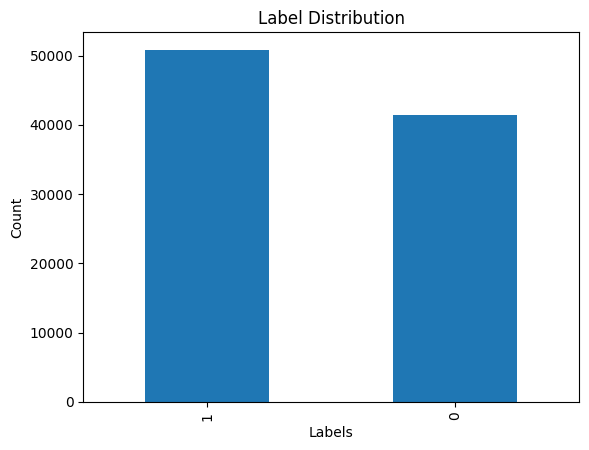

Average length of statements: 13.67 words


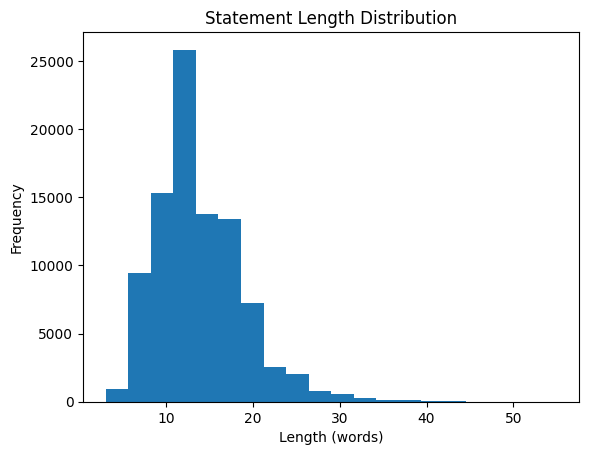

Analyzing table: 2-15401676-3.html.csv
Table ID: 2-15401676-3.html.csv
Shape: (5, 1)
Columns: ['date#result#score#brazil scorers#competition']
First few rows:
  date#result#score#brazil scorers#competition
0          haroldo#south american championship
1           millon#south american championship
2                                          NaN
3                                          NaN
4                                          NaN


In [20]:
# Analyze statements
def analyze_statements(df):
    total_statements = len(df)
    print(f"Total statements: {total_statements}")
    
    # Analyze label distribution
    label_counts = df['label'].value_counts()
    print("\nLabel Distribution:")
    print(label_counts)

    # Visualize label distribution
    label_counts.plot(kind='bar', title="Label Distribution")
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.show()

# Analyze statement length
def analyze_statement_length(df):
    statement_lengths = df['statement'].apply(lambda x: len(x.split()))  # Calculate length of each statement
    print(f"Average length of statements: {statement_lengths.mean():.2f} words")
    
    # Visualize statement length distribution
    statement_lengths.plot(kind='hist', bins=20, title="Statement Length Distribution")
    plt.xlabel("Length (words)")
    plt.ylabel("Frequency")
    plt.show()

# Analyze a specific table
def analyze_table_structure(df, table_id):
    # Filter rows for the specific table
    table_data = df[df['table_id'] == table_id]['table_data'].iloc[0]
    table_df = pd.DataFrame(table_data)  # Convert back to DataFrame
    print(f"Table ID: {table_id}")
    print(f"Shape: {table_df.shape}")
    print(f"Columns: {list(table_df.columns)}")
    print(f"First few rows:\n{table_df.head()}")

# Run the updated analyses
print("Training Data Analysis")
analyze_statements(df)
analyze_statement_length(df)

# Analyze a specific table
example_table_id = df['table_id'].iloc[0]  # Get an example table ID
print(f"Analyzing table: {example_table_id}")
analyze_table_structure(df, example_table_id)

### Analysis by metadata

Training Metadata Analysis

Label Distribution by Metadata:
label                   0   1
metadata                     
$40 a day               7  10
$h*! my dad says        5   5
.375 dakota             0   5
.38 special             3   7
0 - 6 - 0 + 0 - 6 - 0   4   4
...                    ..  ..
éric bernard            1   1
éric prodon            14  14
örebro sk               5   5
đorđe jokić             0   1
łomża governorate       2   4

[8262 rows x 2 columns]


/var/folders/2k/24_q_dz17w11fkz1_6hr6h840000gn/T/ipykernel_42905/623375000.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


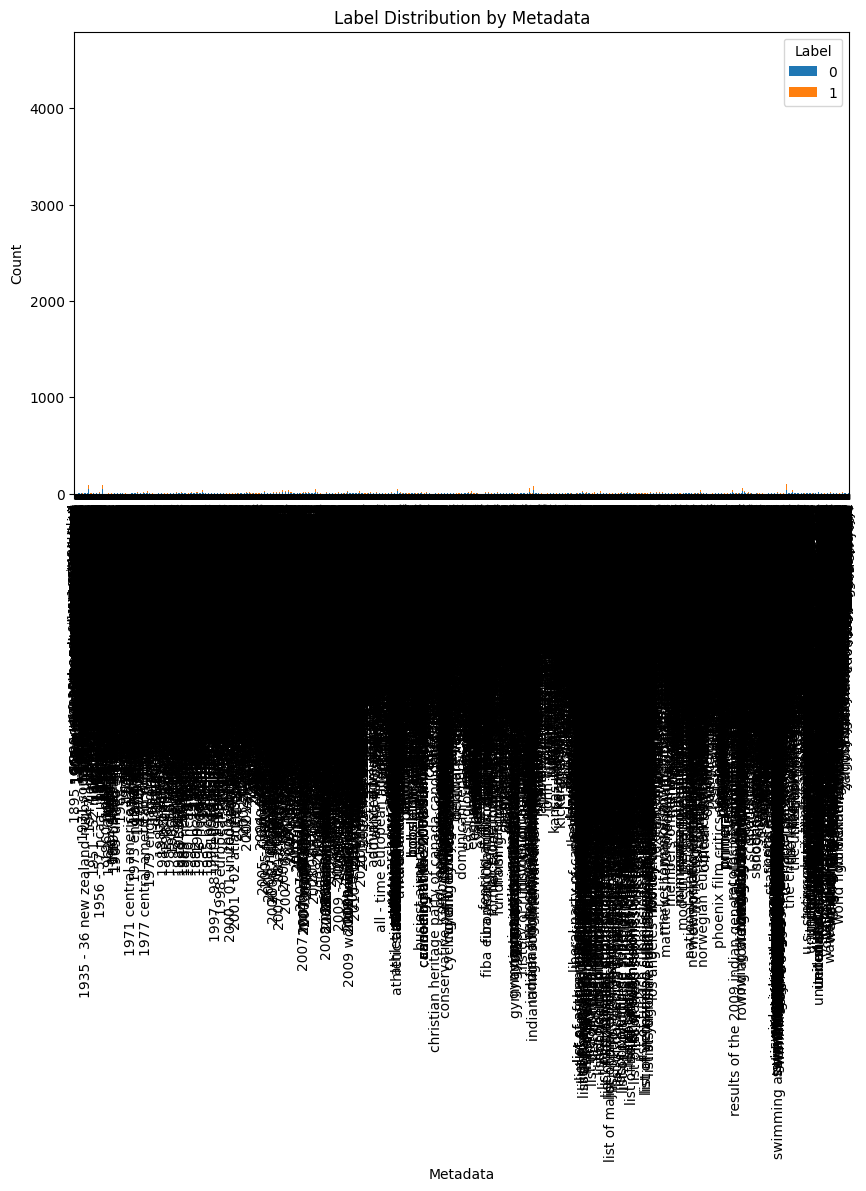


Average Statement Length by Metadata:
metadata
$40 a day                13.529412
$h*! my dad says         14.300000
.375 dakota               9.800000
.38 special              16.500000
0 - 6 - 0 + 0 - 6 - 0    11.750000
                           ...    
éric bernard              8.000000
éric prodon              14.821429
örebro sk                14.400000
đorđe jokić              19.000000
łomża governorate         8.666667
Name: statement, Length: 8262, dtype: float64


/var/folders/2k/24_q_dz17w11fkz1_6hr6h840000gn/T/ipykernel_42905/623375000.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


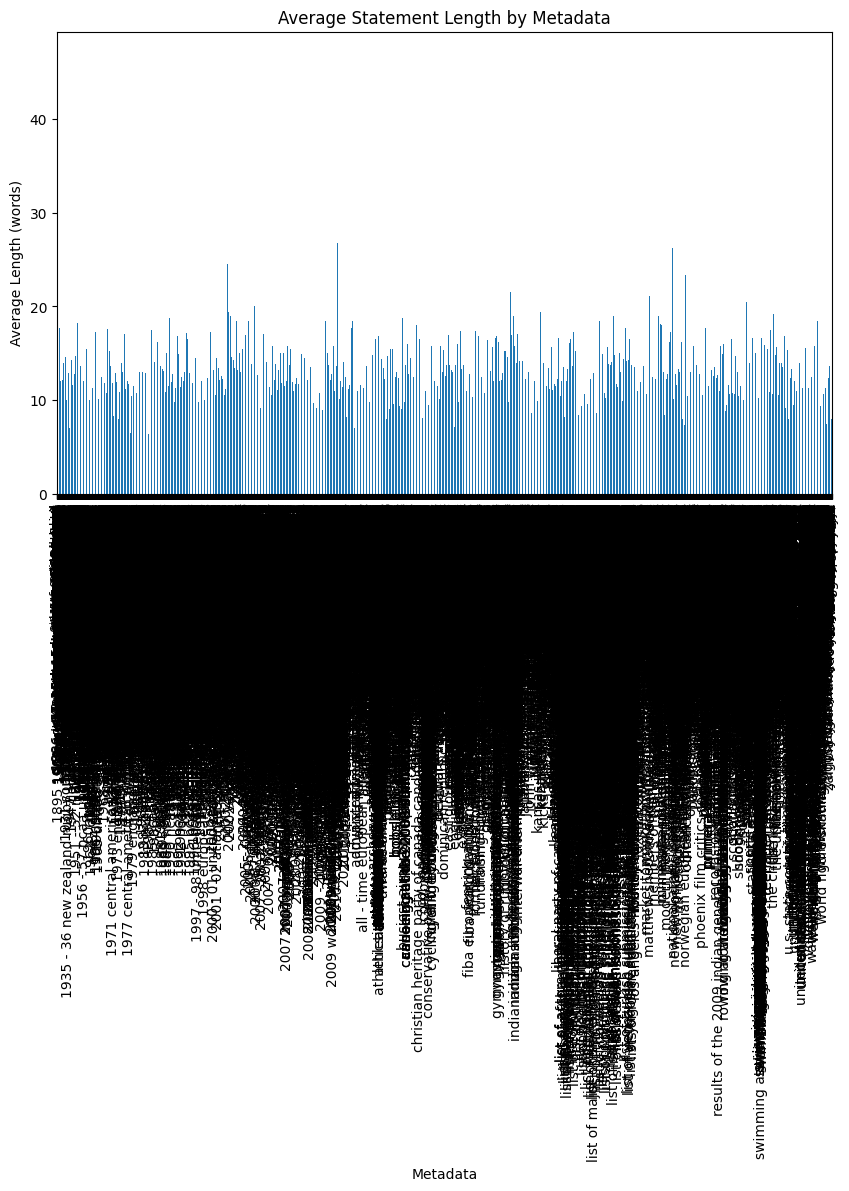

In [21]:
def analyze_label_distribution_by_metadata(df):
    metadata_label_counts = df.groupby('metadata')['label'].value_counts().unstack(fill_value=0)
    print("\nLabel Distribution by Metadata:")
    print(metadata_label_counts)
    
    # Visualize label distribution for each metadata
    metadata_label_counts.plot(kind='bar', stacked=True, figsize=(10, 6), title="Label Distribution by Metadata")
    plt.xlabel("Metadata")
    plt.ylabel("Count")
    plt.legend(title="Label")
    plt.tight_layout()
    plt.show()

def analyze_statement_length_by_metadata(df):
    statement_lengths = df['statement'].apply(lambda x: len(x.split()))
    avg_length_by_metadata = df.groupby('metadata')['statement'].apply(lambda x: x.str.split().str.len().mean())
    print("\nAverage Statement Length by Metadata:")
    print(avg_length_by_metadata)
    
    # Visualize average length by metadata
    avg_length_by_metadata.plot(kind='bar', figsize=(10, 6), title="Average Statement Length by Metadata")
    plt.xlabel("Metadata")
    plt.ylabel("Average Length (words)")
    plt.tight_layout()
    plt.show()

# Run the updated analyses
print("Training Metadata Analysis")
analyze_label_distribution_by_metadata(df)
analyze_statement_length_by_metadata(df)

## Analysis of table content:


Table Structure Summary:
           num_rows      num_cols
count  92283.000000  92283.000000
mean      12.864092      1.010869
std        8.437016      0.157738
min        1.000000      1.000000
25%        6.000000      1.000000
50%       10.000000      1.000000
75%       16.000000      1.000000
max       48.000000      7.000000


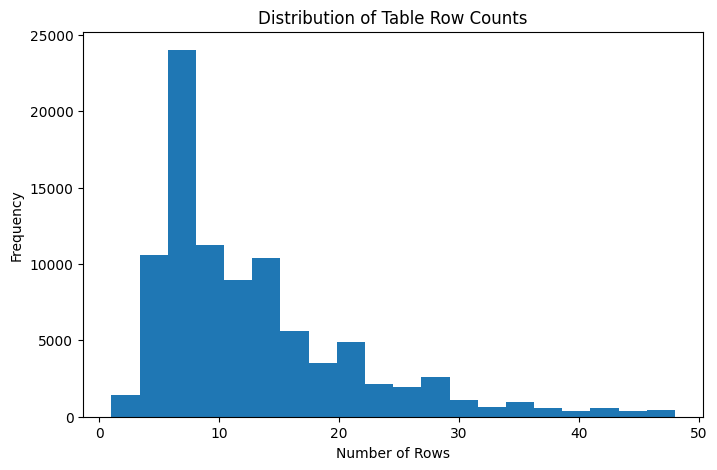

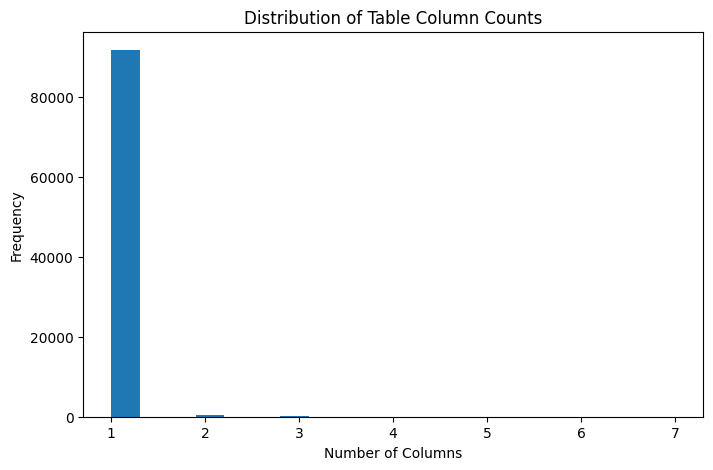

In [22]:
def analyze_table_content(df):
    table_shapes = df['table_data'].apply(lambda x: (len(x), len(x[0]) if len(x) > 0 else 0))
    df['num_rows'], df['num_cols'] = zip(*table_shapes)
    
    print("\nTable Structure Summary:")
    print(df[['num_rows', 'num_cols']].describe())
    
    # Visualize table row and column counts
    df['num_rows'].plot(kind='hist', bins=20, title="Distribution of Table Row Counts", figsize=(8, 5))
    plt.xlabel("Number of Rows")
    plt.ylabel("Frequency")
    plt.show()

    df['num_cols'].plot(kind='hist', bins=20, title="Distribution of Table Column Counts", figsize=(8, 5))
    plt.xlabel("Number of Columns")
    plt.ylabel("Frequency")
    plt.show()

# Run the updated analyses
analyze_table_content(df)